### import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from datasist.structdata import detect_outliers
sns.set(rc={'figure.figsize': [20, 10]}, font_scale=1.3)

## Bussiness Understanding

1. 10 USD / hour for casual user
2. 3 USD / hour for registred user
3. 14% taxes
4. 2000 USD / year maintainance

# read the dataset

In [2]:
df = pd.read_csv('bikes.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,rented_bikes_count
0,2011-01-01 00:00:00,Spring,0.0,0.0,Clear,9.84,81.0,NaN,3,13,16
1,2011-01-01 01:00:00,Spring,0.0,0.0,NaN,9.02,80.0,0.0,8,32,40
2,2011-01-01 02:00:00,Spring,0.0,0.0,Clear,9.02,NaN,0.0,5,27,32
3,2011-01-01 03:00:00,Spring,0.0,0.0,Clear,9.84,75.0,0.0,3,10,13
4,2011-01-01 04:00:00,NaN,0.0,0.0,Clear,NaN,75.0,NaN,0,1,1


# calculte the profit

In [3]:
# profit = number of casual * 10 + number of registered * 3 - taxes - maintainance per hour
df['profit'] = ((df['casual'] * 10 + df['registered'] * 3 ) * (1 - 0.14)) - (2000 / (365*24))

#### check the df again

In [4]:
df.head()

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,rented_bikes_count,profit
0,2011-01-01 00:00:00,Spring,0.0,0.0,Clear,9.84,81.0,NaN,3,13,16,59.111689
1,2011-01-01 01:00:00,Spring,0.0,0.0,NaN,9.02,80.0,0.0,8,32,40,151.131689
2,2011-01-01 02:00:00,Spring,0.0,0.0,Clear,9.02,NaN,0.0,5,27,32,112.431689
3,2011-01-01 03:00:00,Spring,0.0,0.0,Clear,9.84,75.0,0.0,3,10,13,51.371689
4,2011-01-01 04:00:00,NaN,0.0,0.0,Clear,NaN,75.0,NaN,0,1,1,2.351689


# extract month, hour, and day name from the df

In [5]:
# first convert date to datetime
df['datetime'] = pd.to_datetime(df['datetime'], errors = 'coerce') # use errors to handle any diff format
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day_name()
df['hour'] = df['datetime'].dt.hour

# define a function that maps hours into periods and apply it to the df

In [6]:
def period(x):
    if x>=0 and x<12:
        return 'Morning'
    elif x>=12 and x<16:
        return 'Afternoon'
    else:
        return 'Evening'

In [7]:
df['periods'] = df['hour'].apply(period)

In [8]:
## another way by lambda directly
#df['period'] = df['hour'].apply(lambda x: 'Morning' if x>=0 and x<12 else 'Afternoon' if x>=12 and x<16 else 'Evening')

In [9]:
df.head()

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,rented_bikes_count,profit,month,day,hour,periods
0,2011-01-01 00:00:00,Spring,0.0,0.0,Clear,9.84,81.0,NaN,3,13,16,59.111689,1,Saturday,0,Morning
1,2011-01-01 01:00:00,Spring,0.0,0.0,NaN,9.02,80.0,0.0,8,32,40,151.131689,1,Saturday,1,Morning
2,2011-01-01 02:00:00,Spring,0.0,0.0,Clear,9.02,NaN,0.0,5,27,32,112.431689,1,Saturday,2,Morning
3,2011-01-01 03:00:00,Spring,0.0,0.0,Clear,9.84,75.0,0.0,3,10,13,51.371689,1,Saturday,3,Morning
4,2011-01-01 04:00:00,NaN,0.0,0.0,Clear,NaN,75.0,NaN,0,1,1,2.351689,1,Saturday,4,Morning


# get the df statistics

In [10]:
df.describe()

,holiday,workingday,temp,humidity,windspeed,casual,registered,rented_bikes_count,profit,month,hour
count,10030.000000,9388.000000,8104.000000,7462.000000,6820.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.029113,0.678206,20.317665,61.790673,12.708806,36.021955,155.552177,191.574132,710.885118,6.521495,11.541613
std,0.168131,0.467189,7.818568,19.262084,8.131154,49.960477,151.039033,181.144454,709.202461,3.444373,6.915838
min,0.000000,0.000000,0.820000,0.000000,0.000000,0.000000,0.000000,1.000000,2.351689,1.000000,0.000000
25%,0.000000,0.000000,13.940000,47.000000,7.001500,4.000000,36.000000,42.000000,142.531689,4.000000,6.000000
50%,0.000000,1.000000,20.500000,62.000000,12.998000,17.000000,118.000000,145.000000,500.291689,7.000000,12.000000
75%,0.000000,1.000000,26.240000,77.000000,16.997900,49.000000,222.000000,284.000000,1051.551689,10.000000,18.000000
max,1.000000,1.000000,41.000000,100.000000,56.996900,367.000000,886.000000,977.000000,4126.911689,12.000000,23.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            10886 non-null  datetime64[ns]
 1   season              10672 non-null  object        
 2   holiday             10030 non-null  float64       
 3   workingday          9388 non-null   float64       
 4   weather             8746 non-null   object        
 5   temp                8104 non-null   float64       
 6   humidity            7462 non-null   float64       
 7   windspeed           6820 non-null   float64       
 8   casual              10886 non-null  int64         
 9   registered          10886 non-null  int64         
 10  rented_bikes_count  10886 non-null  int64         
 11  profit              10886 non-null  float64       
 12  month               10886 non-null  int64         
 13  day                 10886 non-null  object    

there are missing values

#### which day has the maximum profit

In [12]:
df.loc[df['profit']==df['profit'].max(), 'day']

9415    Saturday
Name: day, dtype: object

#### which day has the minimum profit

In [13]:
df.loc[df['profit']==df['profit'].min(), 'datetime']

4       2011-01-01 04:00:00
5       2011-01-01 05:00:00
30      2011-01-02 07:00:00
49      2011-01-03 04:00:00
71      2011-01-04 02:00:00
                ...        
6884    2012-04-05 04:00:00
7051    2012-04-12 04:00:00
7433    2012-05-09 02:00:00
10288   2012-11-14 02:00:00
10672   2012-12-11 02:00:00
Name: datetime, Length: 96, dtype: datetime64[ns]

#### get the statistics of the profit for each period and report your findings

In [14]:
df.groupby('periods')['profit'].describe()

,count,mean,std,min,25%,50%,75%,max
periods,,,,,,,,
Afternoon,1824.0,1097.276437,785.104120,7.511689,553.396689,876.111689,1433.606689,4095.951689
Evening,3648.0,969.344601,730.656533,15.251689,391.071689,773.771689,1398.346689,4126.911689
Morning,5414.0,406.555978,506.144188,2.351689,43.631689,182.951689,601.556689,3222.191689


#### get the statistics of the profit for each week dayand report your findings

In [15]:
df.groupby('day')['profit'].describe()

,count,mean,std,min,25%,50%,75%,max
day,,,,,,,,
Friday,1529.0,696.841905,613.628926,2.351689,172.631689,585.431689,1048.111689,3272.931689
Monday,1551.0,670.640445,626.448152,2.351689,140.381689,520.931689,1026.181689,3165.431689
Saturday,1584.0,890.190932,929.497164,2.351689,161.881689,524.801689,1411.676689,4126.911689
Sunday,1579.0,809.787117,827.622847,2.351689,159.301689,442.671689,1312.991689,3697.771689
Thursday,1553.0,653.318528,612.017117,2.351689,137.371689,519.211689,982.751689,3096.631689
Tuesday,1539.0,627.594042,602.149032,2.351689,120.601689,477.931689,956.091689,3513.731689
Wednesday,1551.0,621.452992,625.409320,2.351689,120.601689,452.991689,933.731689,3072.551689


#### get the statistics of the profit for holidays and report your findings

In [16]:
df.groupby('holiday')['profit'].describe()

,count,mean,std,min,25%,50%,75%,max
holiday,,,,,,,,
0.0,9738.0,709.165095,708.871793,2.351689,140.811689,499.861689,1048.111689,4126.911689
1.0,292.0,768.944498,759.497973,4.931689,142.316689,502.011689,1243.331689,2848.091689


#### get the statistics of the profit for each type of weather and report your findings

In [17]:
df.groupby('weather')['profit'].describe()

,count,mean,std,min,25%,50%,75%,max
weather,,,,,,,,
Clear,5793.0,766.381153,742.228818,2.351689,158.871689,564.791689,1140.131689,4056.391689
Mist,2259.0,649.365589,634.182907,2.351689,136.511689,471.051689,983.611689,4126.911689
Rainy,693.0,411.097404,507.688309,2.351689,74.591689,226.811689,533.831689,2930.651689
Snowy,1.0,459.011689,NaN,459.011689,459.011689,459.011689,459.011689,459.011689


# plot the correlation heatmap what can you see?

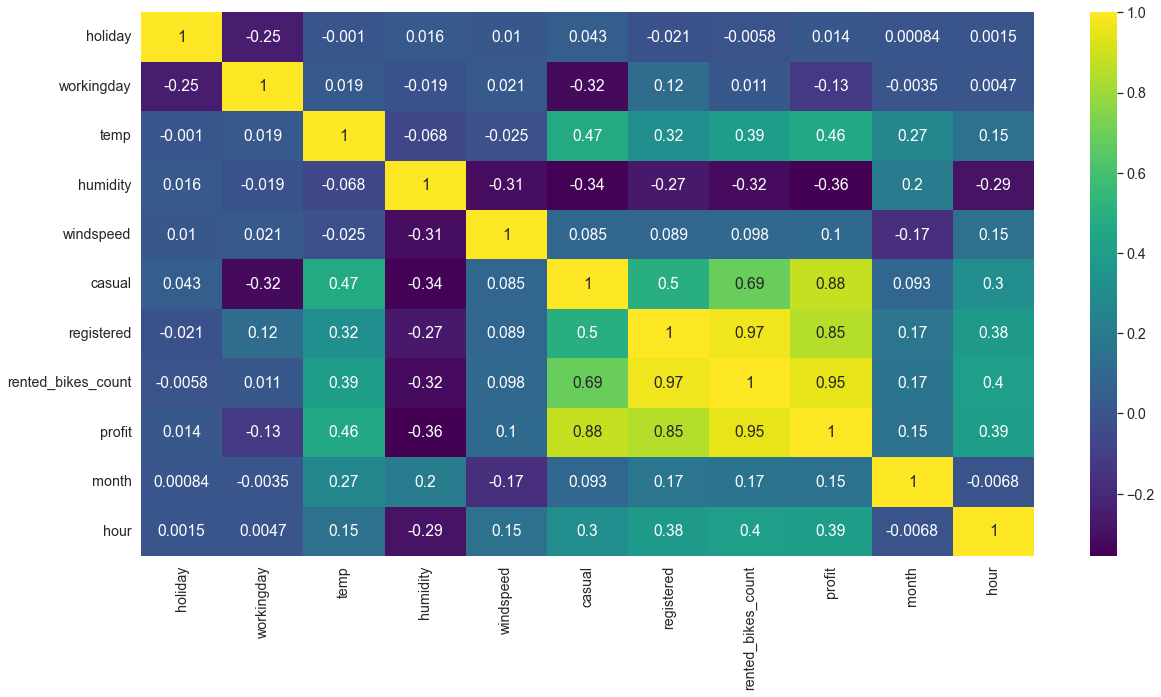

In [18]:
sns.heatmap(df.corr(), annot=True ,cmap='viridis');

we can get directly the columns the correlate with profit and know if there's any feature correlate with other

### describe the distribution of the profit according to the weather

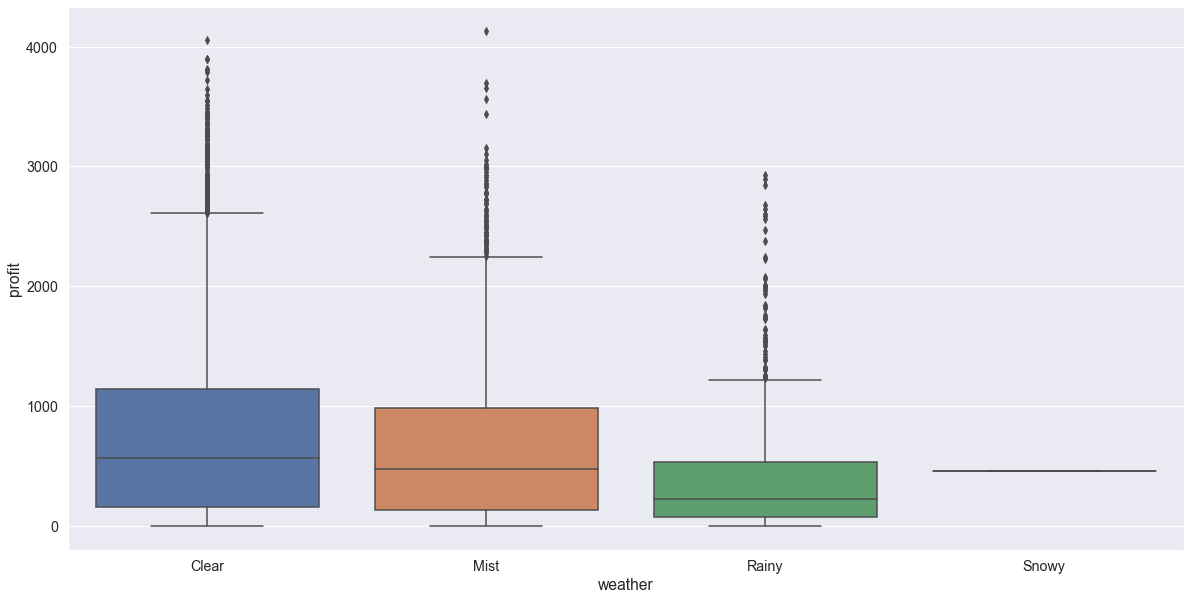

In [19]:
sns.boxplot(data=df,x='weather', y ='profit');

there are a lot of outliers and the distribution skewed to right

In [20]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'humidity', 'windspeed', 'casual', 'registered', 'rented_bikes_count',
       'profit', 'month', 'day', 'hour', 'periods'],
      dtype='object')

# get the missing values

In [21]:
# put the missing values in season column
df['season'] = df['month'].apply(lambda x: 'Spring' if x>=1 and x<=3 else 'Summer' if x>= 4 and x<=6 else 'Fall' if x>=7 and x<=9 else 'Winter')

In [22]:
# use mode -> most_frequent
imputer = SimpleImputer(strategy='most_frequent')
df['weather'] = imputer.fit_transform(df[['weather']])
df['holiday'] = imputer.fit_transform(df[['holiday']])
# use mean
imputer2 = SimpleImputer(strategy='mean')
df['temp'] = imputer2.fit_transform(df[['temp']])
df['humidity'] = imputer2.fit_transform(df[['humidity']])
df['workingday'] = imputer2.fit_transform(df[['workingday']])
df['windspeed'] = imputer2.fit_transform(df[['windspeed']])

#### for each column get the percentage of the missing data

In [23]:
(df.isna().sum() / len(df)) * 100

datetime              0.0
season                0.0
holiday               0.0
workingday            0.0
weather               0.0
temp                  0.0
humidity              0.0
windspeed             0.0
casual                0.0
registered            0.0
rented_bikes_count    0.0
profit                0.0
month                 0.0
day                   0.0
hour                  0.0
periods               0.0
dtype: float64

# remove the outliers

In [24]:
indexes = detect_outliers(df, n=0, features=['temp','humidity'])

In [25]:
df.drop(indexes, axis=0, inplace=True)

# one hot encode the cat data

In [26]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'humidity', 'windspeed', 'casual', 'registered', 'rented_bikes_count',
       'profit', 'month', 'day', 'hour', 'periods'],
      dtype='object')

In [27]:
df = pd.get_dummies(df, columns=['season', 'weather'], prefix="", prefix_sep="", drop_first=True)
df.head()

,datetime,holiday,workingday,temp,humidity,windspeed,casual,registered,rented_bikes_count,profit,month,day,hour,periods,Spring,Summer,Winter,Mist,Rainy,Snowy
0,2011-01-01 00:00:00,0.0,0.0,9.840000,81.000000,12.708806,3,13,16,59.111689,1,Saturday,0,Morning,1,0,0,0,0,0
1,2011-01-01 01:00:00,0.0,0.0,9.020000,80.000000,0.000000,8,32,40,151.131689,1,Saturday,1,Morning,1,0,0,0,0,0
2,2011-01-01 02:00:00,0.0,0.0,9.020000,61.790673,0.000000,5,27,32,112.431689,1,Saturday,2,Morning,1,0,0,0,0,0
3,2011-01-01 03:00:00,0.0,0.0,9.840000,75.000000,0.000000,3,10,13,51.371689,1,Saturday,3,Morning,1,0,0,0,0,0
4,2011-01-01 04:00:00,0.0,0.0,20.317665,75.000000,12.708806,0,1,1,2.351689,1,Saturday,4,Morning,1,0,0,0,0,0


In [28]:
len(df.columns)

20

# Split the data

In [29]:
x = df.drop(columns=['profit', 'datetime', 'day', 'periods'], axis=1)
y = df['profit']

In [30]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2, random_state=42)

In [31]:
# look to data
display(xtrain.head())
display(xtest.head())
display(ytrain.head())
ytest.head()

,holiday,workingday,temp,humidity,windspeed,casual,registered,rented_bikes_count,month,hour,Spring,Summer,Winter,Mist,Rainy,Snowy
2775,1.0,0.0,31.98,49.000000,0.000000,242,181,423,7,13,0,0,0,1,0,0
8994,0.0,1.0,26.24,61.790673,7.001500,0,6,6,8,3,0,0,0,0,0,0
9205,0.0,1.0,26.24,89.000000,11.001400,24,193,217,9,22,0,0,0,0,0,0
6264,0.0,1.0,11.48,61.790673,8.998100,1,70,71,2,6,1,0,0,1,0,0
5985,0.0,0.0,12.30,61.000000,12.708806,40,203,243,2,14,1,0,0,0,0,0


,holiday,workingday,temp,humidity,windspeed,casual,registered,rented_bikes_count,month,hour,Spring,Summer,Winter,Mist,Rainy,Snowy
7929,0.0,0.000000,33.620000,61.790673,15.001300,164,326,490,6,18,0,1,0,0,0,0
8383,0.0,1.000000,32.800000,43.000000,15.001300,89,346,435,7,16,0,0,0,0,0,0
2275,0.0,1.000000,31.160000,61.790673,12.708806,88,484,572,6,17,0,1,0,0,0,0
7829,0.0,1.000000,20.317665,38.000000,12.708806,111,191,302,6,14,0,1,0,0,0,0
10583,0.0,0.678206,12.300000,81.000000,8.998100,10,291,301,12,9,0,0,1,1,0,0


2775    2547.951689
8994      15.251689
9205     704.111689
6264     188.971689
5985     867.511689
Name: profit, dtype: float64

7929     2251.251689
8383     1657.851689
2275     2005.291689
7829     1447.151689
10583     836.551689
Name: profit, dtype: float64

# scale features

In [32]:
scaler = StandardScaler()

xtrain[['temp', 'humidity', 'casual', 'registered', 'rented_bikes_count']]=scaler.fit_transform(xtrain[['temp', 'humidity', 'casual', 'registered', 'rented_bikes_count']])
xtest[['temp', 'humidity', 'casual', 'registered', 'rented_bikes_count']]=scaler.fit_transform(xtest[['temp', 'humidity', 'casual', 'registered', 'rented_bikes_count']])

In [33]:
# look to data
display(xtrain.head(2))
display(xtest.head(2))

,holiday,workingday,temp,humidity,windspeed,casual,registered,rented_bikes_count,month,hour,Spring,Summer,Winter,Mist,Rainy,Snowy
2775,1.0,0.0,1.765765,-0.932141,0.0000,4.175539,0.171153,1.285831,7,13,0,0,0,1,0,0
8994,0.0,1.0,0.903155,-0.042559,7.0015,-0.722479,-0.989180,-1.024174,8,3,0,0,0,0,0,0


,holiday,workingday,temp,humidity,windspeed,casual,registered,rented_bikes_count,month,hour,Spring,Summer,Winter,Mist,Rainy,Snowy
7929,0.0,0.0,1.975682,-0.060946,15.0013,2.620155,1.134144,1.668632,6,18,0,1,0,0,0,0
8383,0.0,1.0,1.852745,-1.348904,15.0013,1.098329,1.266698,1.362972,7,16,0,0,0,0,0,0


# Model

In [34]:
model = LinearRegression()

In [35]:
model.fit(xtrain, ytrain)

LinearRegression()

In [36]:
y_pred = model.predict(xtest)
y_pred

array([2262.75517174, 1667.72868696, 2015.69057203, ...,  309.50956833,
       2174.92974015,  560.12363259])

# Evaluate Model

In [37]:
# two ways
mae = mean_absolute_error(ytest, y_pred)
print('mean absolute error :', mae.round(4))
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
print('mean squared error ', rmse.round(4))

mean absolute error : 7.8919
mean squared error  8.0335
